In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')

from astroLuSt.preprocessing import (
    binning, dataseries_manipulation, hps, pdm, sigmaclipping
)

np.random.seed(0)

import importlib
importlib.reload(binning)
importlib.reload(dataseries_manipulation)
importlib.reload(hps)
importlib.reload(pdm)
importlib.reload(sigmaclipping)

#style for plotting
plt.style.use('astroLuSt.styles.LuSt_style')

# Generate (periodic) time-series

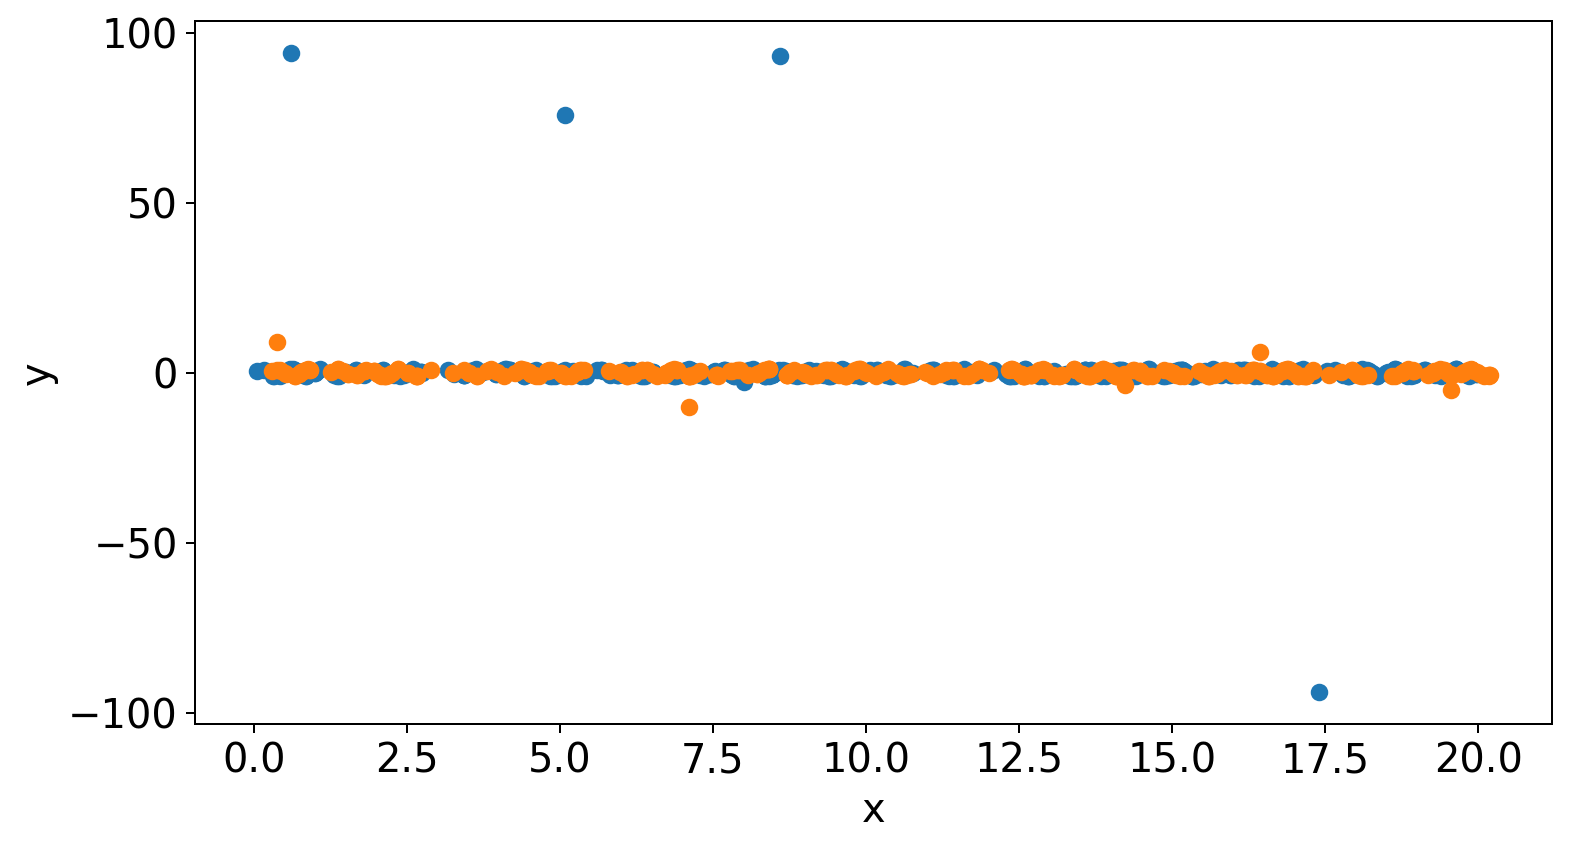

In [2]:
p = 0.5
x = np.linspace(0,20,1000)
x += np.random.normal(size=x.shape)*0.05
y = np.sin(x*2*np.pi/0.5)  + np.random.normal(size=x.shape)*0.05

#randomly sample from x and y
randidxs1 = np.random.choice(np.arange(0, x.shape[0], 1), size=400)
randidxs2 = np.random.choice(np.arange(0, x.shape[0], 1), size=400)


x1 = x[randidxs1]
y1 = y[randidxs1]

x2 = x[randidxs2]+p/2
y2 = y[randidxs2]

#random large outliers
randidxs_out1 = np.random.choice(np.arange(0, x1.shape[0], 1), size=5)
randidxs_out2 = np.random.choice(np.arange(0, x1.shape[0], 1), size=5)
y1[randidxs_out1] *= 1E2
y2[randidxs_out2] *= 1E1

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x1, y1)
ax1.scatter(x2, y2)

ax1.set_xlabel('x')
ax1.set_ylabel('y')
plt.show()


# Period Determination

## Phase Dispersion Minimization

Method for period determination according to [Stellingwerf, 1978](https://ui.adsabs.harvard.edu/abs/1978ApJ...224..953S/abstract).

PDM(
    period_start=0.1,
    period_stop=1.4,
    nperiods=100,
    trial_periods=None,
    n_retries=5,
    nperiods_retry=50,
    retry_range=0.1,
    tolerance_expression=*1.01,
    tolerance_decay=0.99,
    breakloop=False,
    variance_mode=interval,
    sort_output_by=periods,
    normalize=False,
    n_jobs=1,
    verbose=3,
    binning_kwargs={'nintervals': 30},
)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

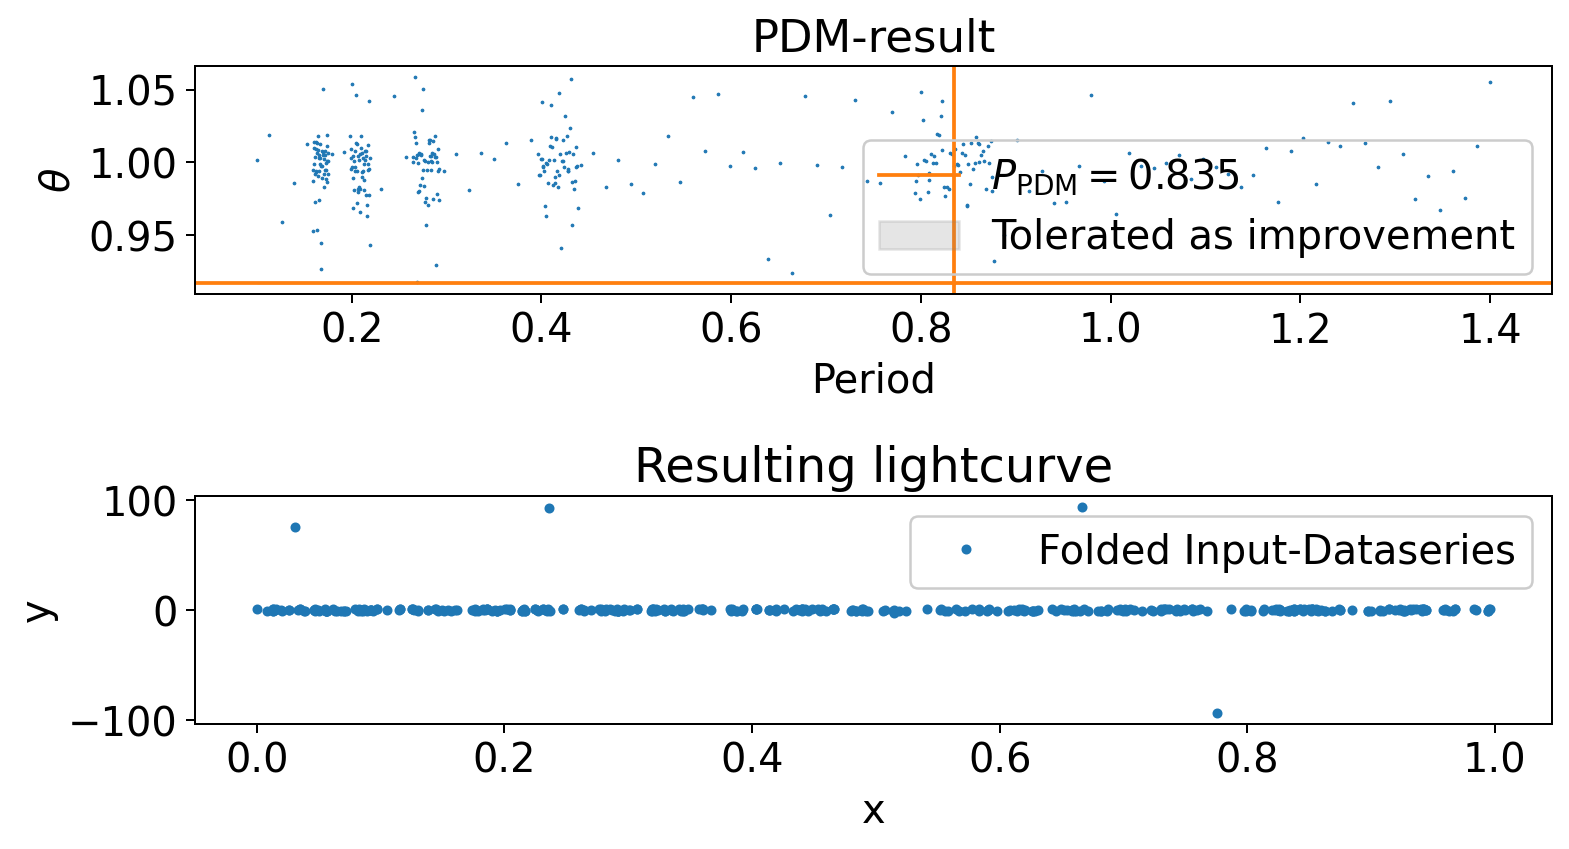

In [3]:
pdm_est = pdm.PDM(
    period_start=0.1, period_stop=1.4, nperiods=100,
    # trial_periods=np.array([0.5, 1, 0.333]),
    n_retries=5,
    tolerance_expression='*1.01',
    tolerance_decay=0.99,
    nperiods_retry=50,
    breakloop=False,
    n_jobs=1,
    verbose=3,
    binning_kwargs={'nintervals':30}
)

print(pdm_est)

pdm_est.fit_predict(x1, y1)
# pdm.fit(x, y)

fig, axs = pdm_est.plot_result()

## Hybrid Period Search (HPS)

Hybrid period finiding algorithm inspired by the one introduced in [Saha et al., 2017](https://ui.adsabs.harvard.edu/abs/2017AJ....154..231S/abstract).

In [4]:
# import pandas as pd
# df = pd.read_csv(r'G:\My Drive\Uni\Physik\Master\Masters Thesis_AI in astronomy\RRLyr_VSX_TESS\data\eleanor_extracted\slurm\tic65992.csv', sep=';')
# df = pd.read_csv(r'G:\My Drive\Uni\Physik\Master\Masters Thesis_AI in astronomy\RRLyr_VSX_TESS\data\eleanor_extracted\slurm\tic1533189.csv', sep=';')
# df = pd.read_csv(r'G:\My Drive\Uni\Physik\Master\Masters Thesis_AI in astronomy\RRLyr_VSX_TESS\data\eleanor_extracted\slurm\tic57466.csv', sep=';')

# x = df['time']
# y = df['corr_flux']
# for s in np.unique(df['sector']):
#     y[df['sector']==s] /= np.nanmedian(y[df['sector']==s])

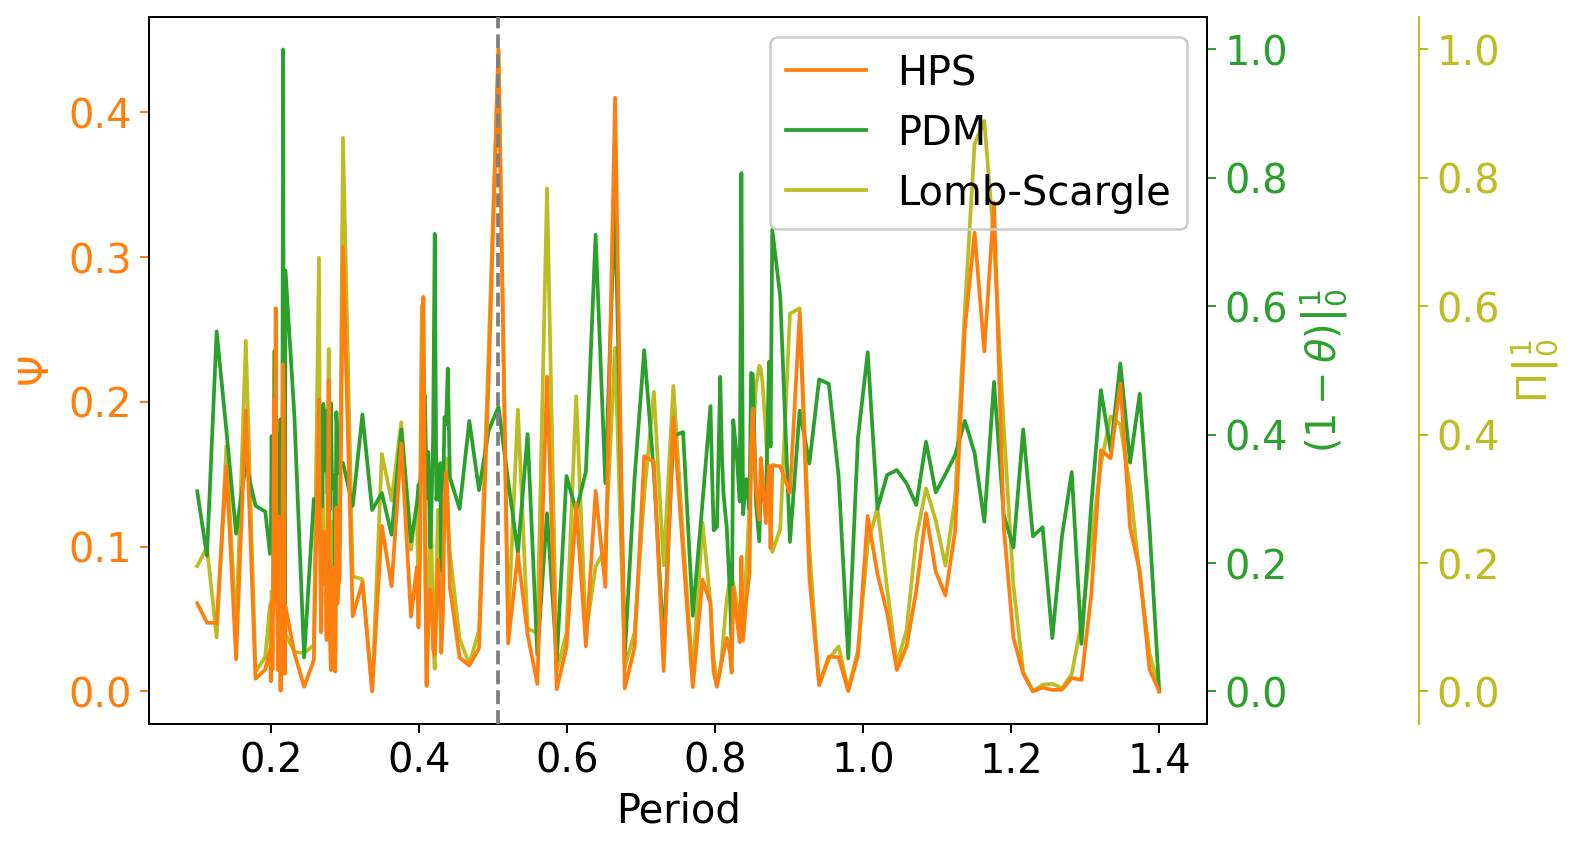

HPS result:          0.507
PDM result:          0.216
Lomb-Scargle result: 0.507


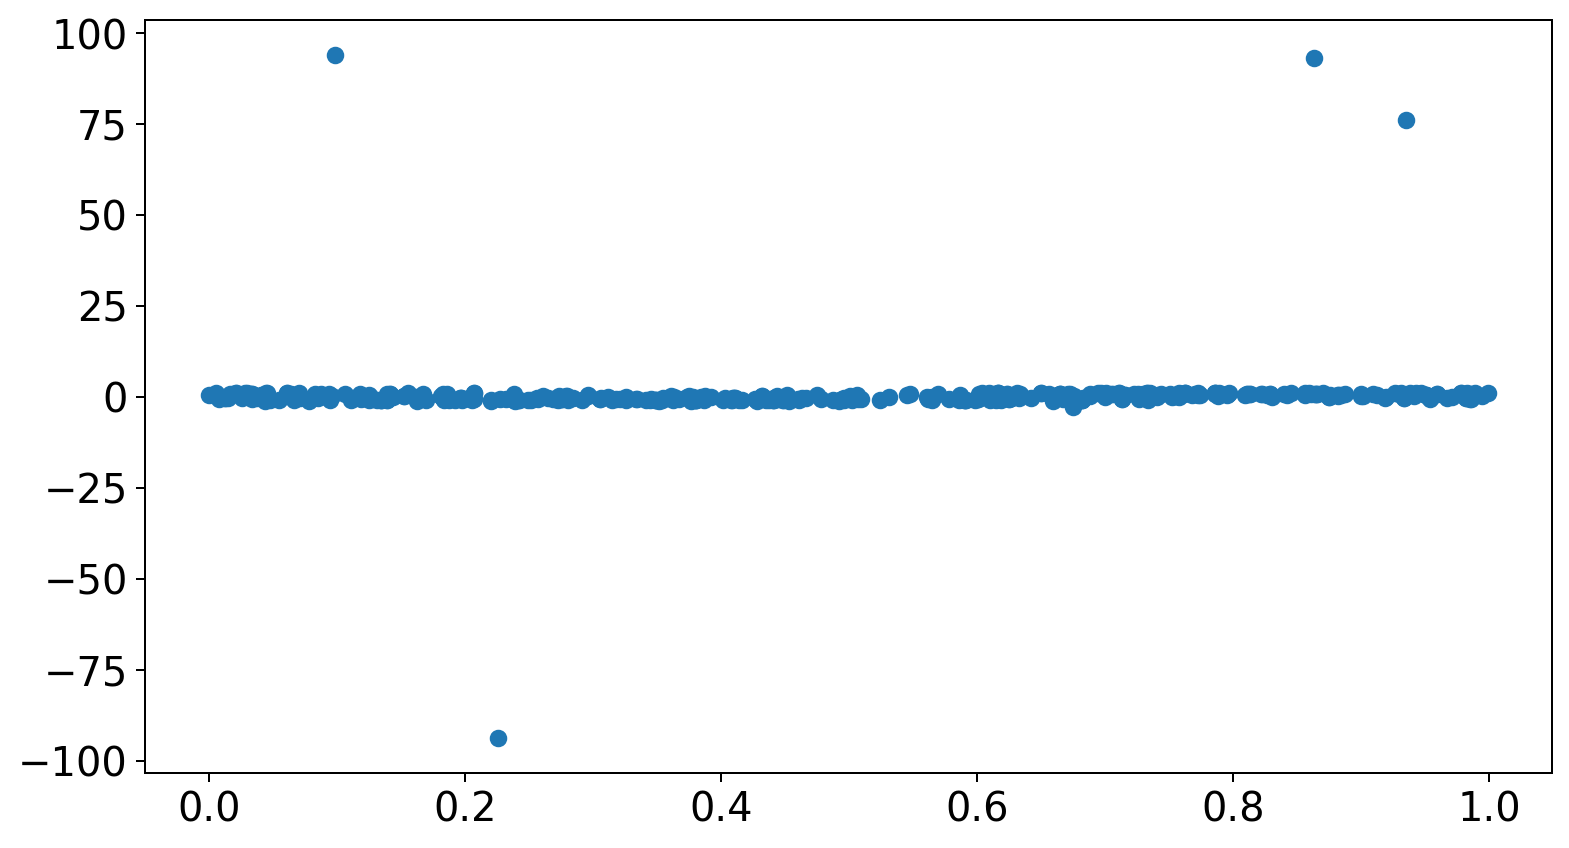

In [5]:
hybps = hps.HPS(
    0.1, 1.4, 100,
    pdm_kwargs={'n_retries':5, 'binning_kwargs':{'nintervals':30}},
    ls_kwargs={'nterms':1}, lsfit_kwargs={'samples_per_peak':5}
)

best_period, best_phi = hybps.fit_predict(x1, y1)
fig, axs = hybps.plot_result(fig_kwargs={'figsize':(9,5)})

print(f'HPS result:          {hybps.best_period:.3f}')
print(f'PDM result:          {hybps.best_period_pdm:.3f}')
print(f'Lomb-Scargle result: {hybps.best_period_ls:.3f}')

#fold dataseries onto period
ph, pe = dataseries_manipulation.fold(x1, best_period)
fig = plt.figure()
plt.scatter(ph, y1)
plt.show()

# Sigma Clipping

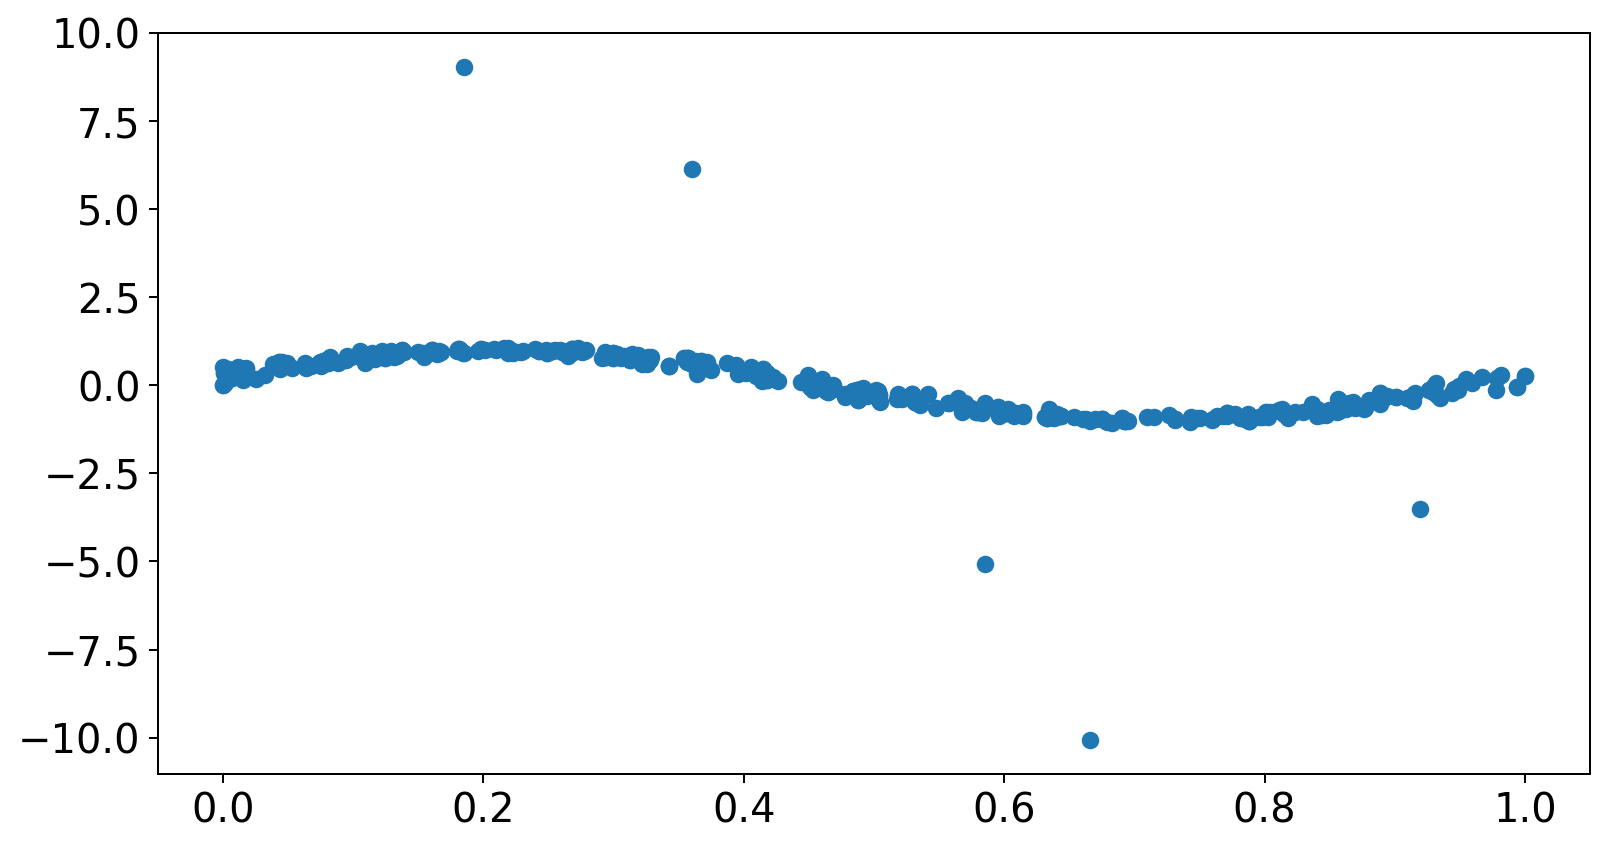

In [6]:
best_period2, best_phi2 = hybps.fit_predict(x2, y2)

#fold dataseries onto period
ph2, pe = dataseries_manipulation.fold(x2, best_period2)
fig = plt.figure()
plt.scatter(ph2, y2)
plt.show()

In [8]:
sigclip = sigmaclipping.SigmaClipping(
    sigma_bottom=1, sigma_top=1,
    bound_history=True, clipmask_history=True,
    verbose=3,
    # binning_kwargs={'nintervals':1}
)

x_clipped, y_clipped = sigclip.fit_transform(
    ph, y1,
    fit_kwargs={'n_iter':2}
)
fig, axs = sigclip.plot_result(show_cut=False, iteration=-1)

# sigclip.fit(
#     ph, y1,
#     mean_x=None, mean_y=None, std_y=None,
#     n_iter=2,
# )
# # fig, axs = sigclip.plot_result(iteration=0)
# fig, axs = sigclip.plot_result(show_cut=False, iteration=-1)

# x_clipped, y_clipped = sigclip.transform(ph, y1)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x_clipped, y_clipped)
plt.show()

INFO(SigmaClipping): Executing iteration #1/2
INFO(SigmaClipping): Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO(Binning): Generated 40 bins
INFO(SigmaClipping): Executing iteration #2/2
INFO(SigmaClipping): Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO(Binning): Generated 40 bins


c:\Users\lukas\Documents\GitHub\astroLuSt\demos\..\astroLuSt\preprocessing\binning.py:343: RuntimeWarning: Mean of empty slice
  self.x_binned  = np.append(self.x_binned,  np.nanmean(self.x[iv_bool]))
c:\Users\lukas\Documents\GitHub\astroLuSt\demos\..\astroLuSt\preprocessing\binning.py:344: RuntimeWarning: Mean of empty slice
  self.y_binned  = np.append(self.y_binned,  np.nanmean(self.y[iv_bool]))
c:\Users\lukas\AppData\Local\Programs\Python\Python310\venvs\astrolust\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


TypeError: SigmaClipping.transform() missing 2 required positional arguments: 'x' and 'y'

INFO(SigmaClipping): Executing iteration #1/2
INFO(SigmaClipping): Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO(Binning): Generated 40 bins
INFO(SigmaClipping): Executing iteration #2/2
INFO(SigmaClipping): Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO(Binning): Generated 40 bins


c:\Users\lukas\Documents\GitHub\astroLuSt\demos\..\astroLuSt\preprocessing\binning.py:343: RuntimeWarning: Mean of empty slice
  self.x_binned  = np.append(self.x_binned,  np.nanmean(self.x[iv_bool]))
c:\Users\lukas\Documents\GitHub\astroLuSt\demos\..\astroLuSt\preprocessing\binning.py:344: RuntimeWarning: Mean of empty slice
  self.y_binned  = np.append(self.y_binned,  np.nanmean(self.y[iv_bool]))
c:\Users\lukas\AppData\Local\Programs\Python\Python310\venvs\astrolust\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


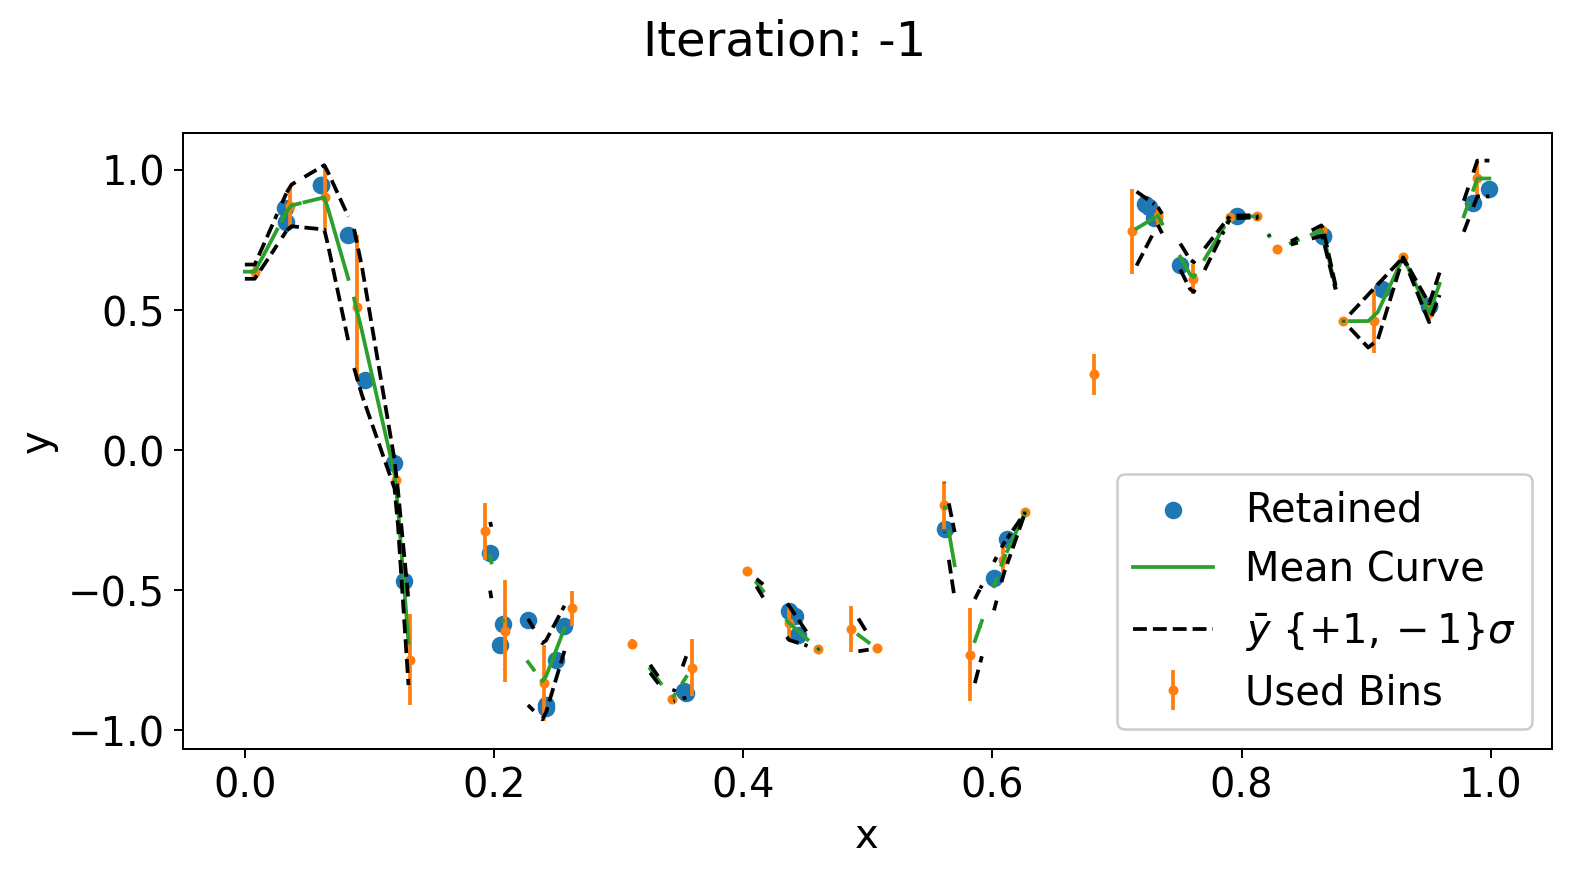

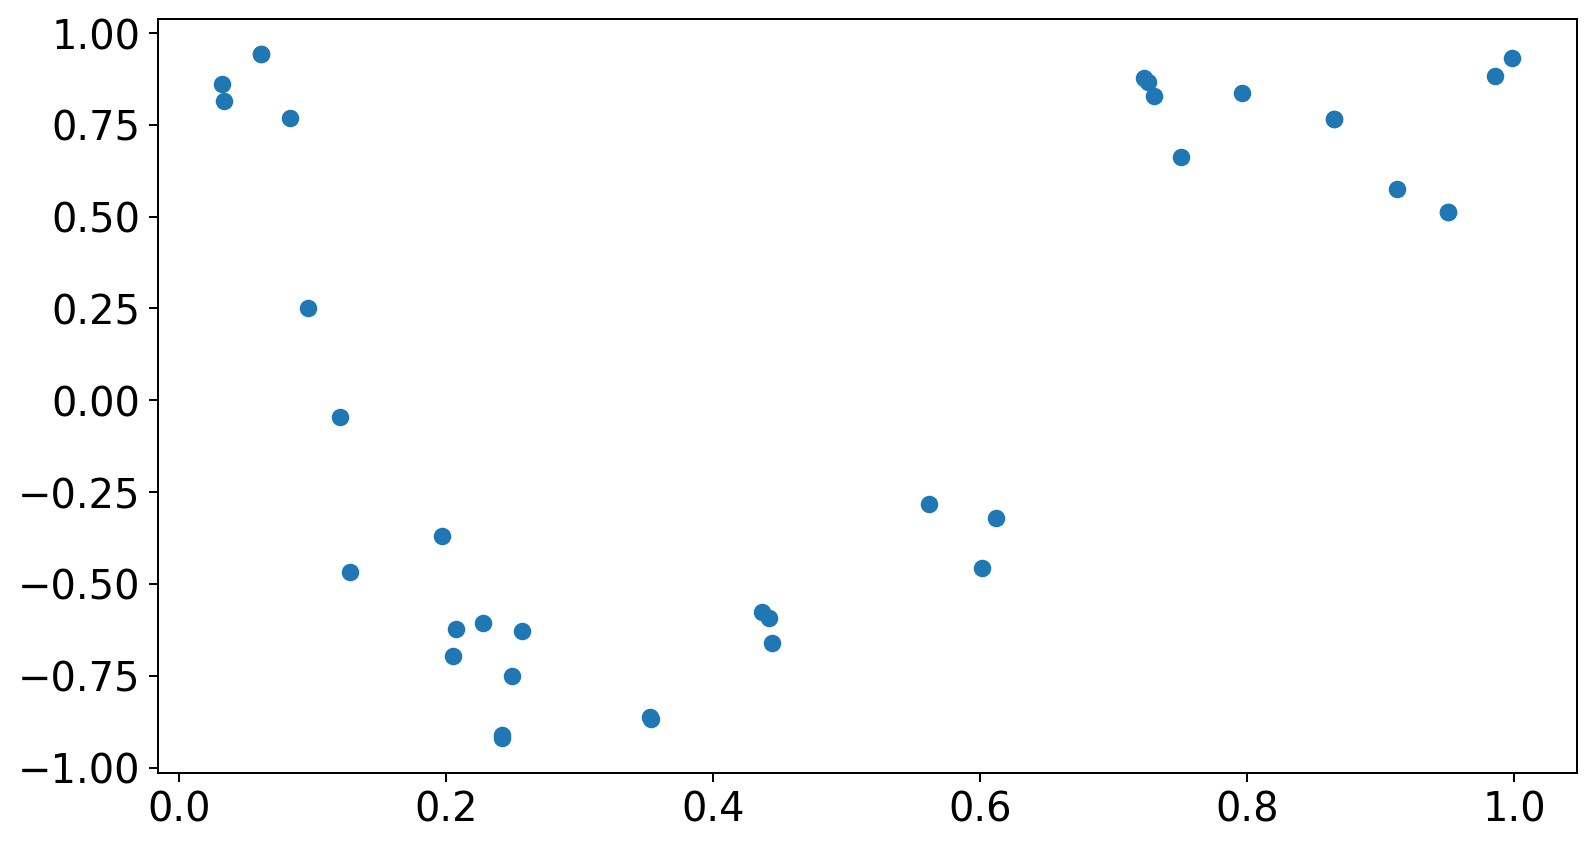

INFO(SigmaClipping): Executing iteration #1/2
INFO(SigmaClipping): Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO(Binning): Generated 40 bins
INFO(SigmaClipping): Executing iteration #2/2
INFO(SigmaClipping): Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO(Binning): Generated 40 bins


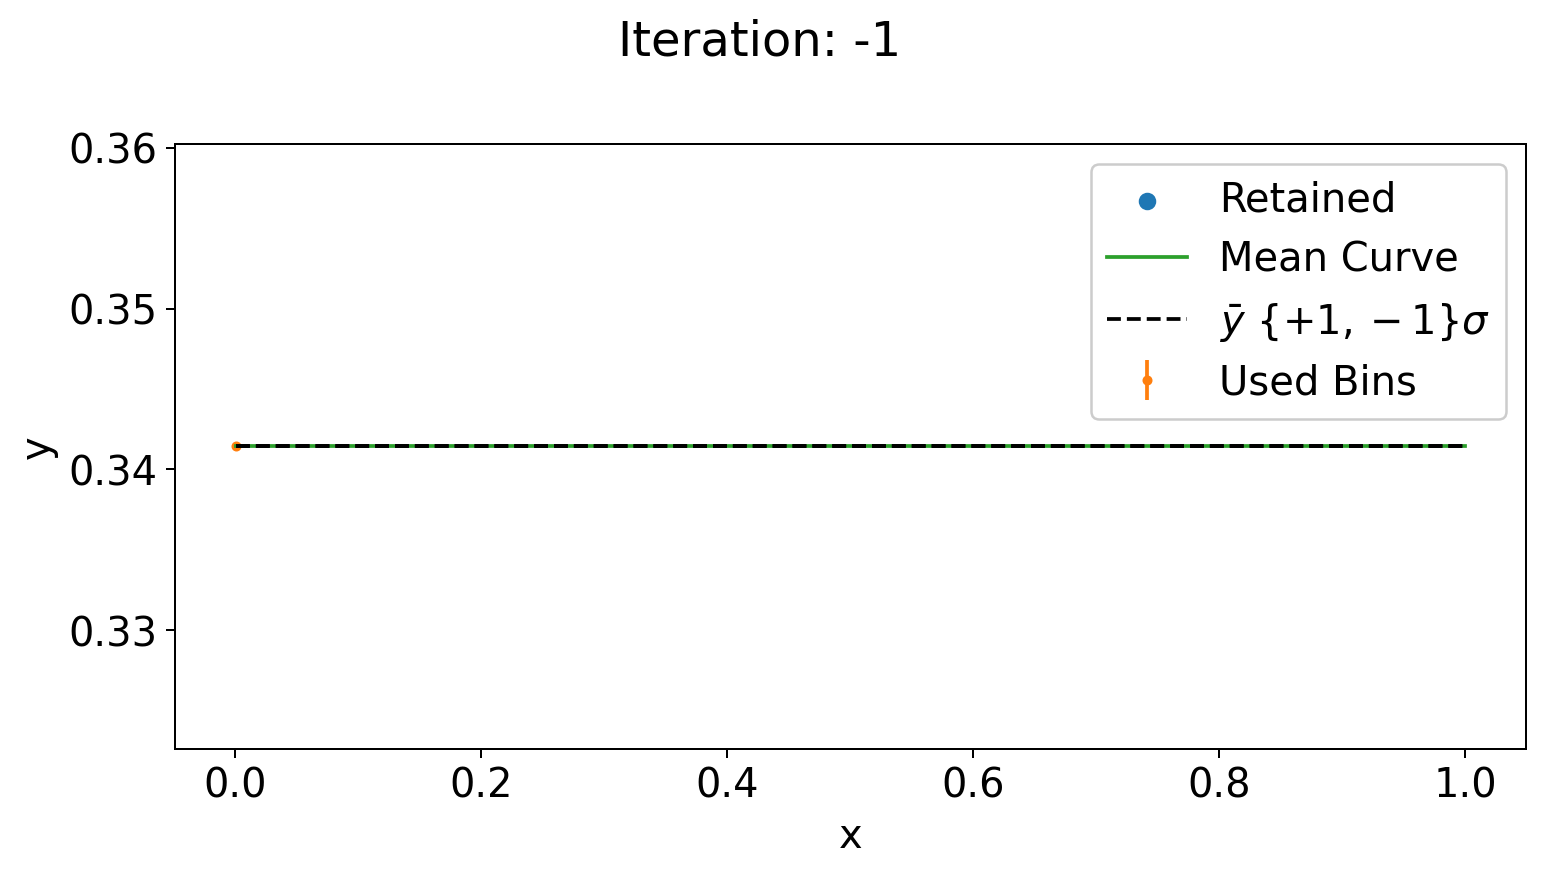

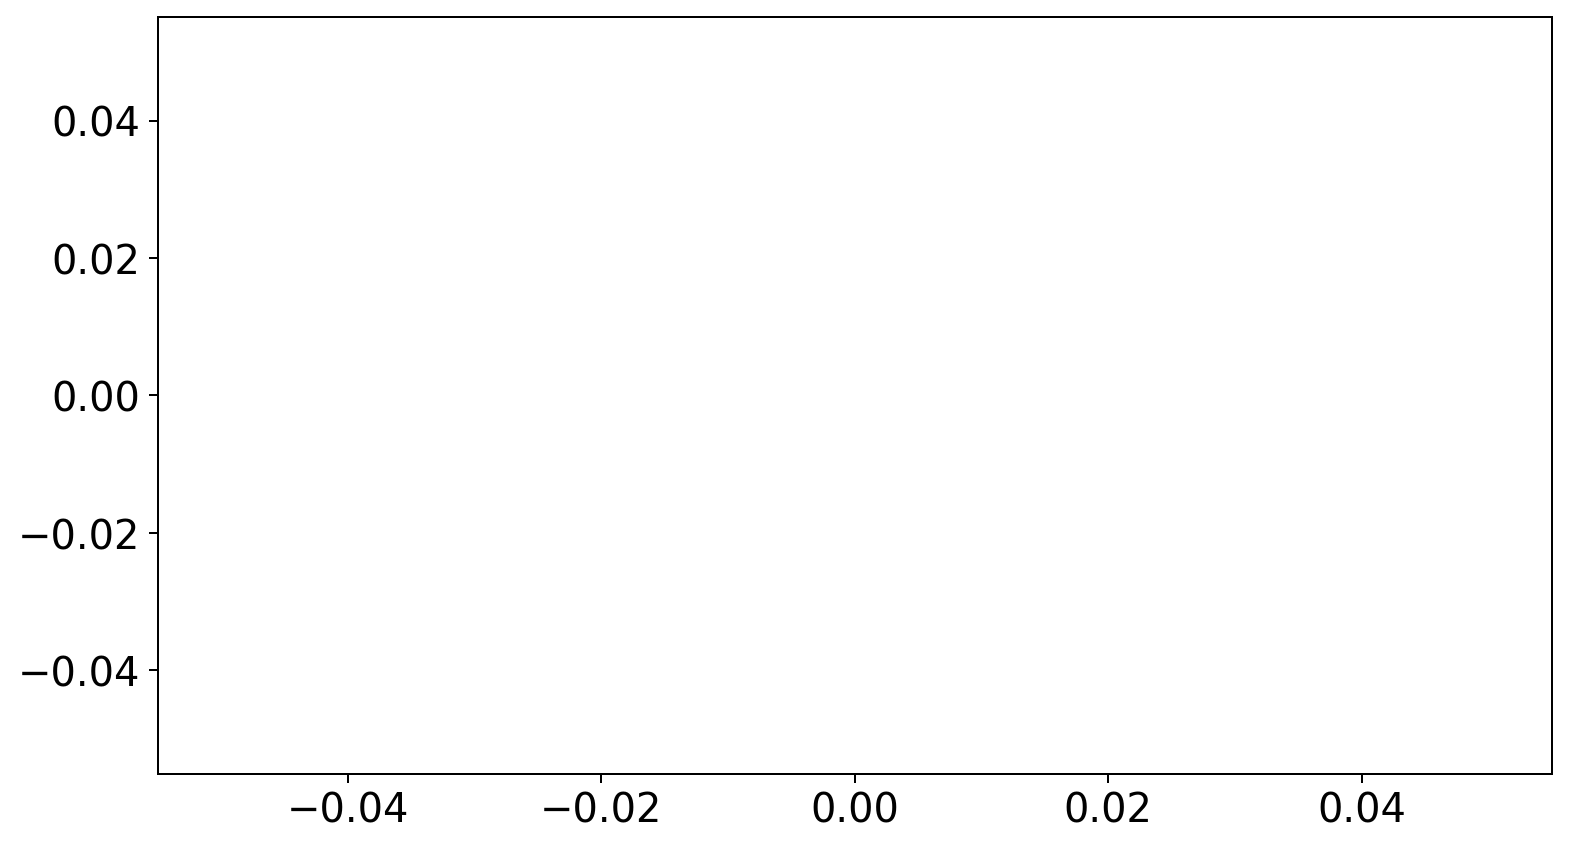

In [ ]:


for phi, y in zip([ph, ph2], [y1, y2]):

    sigclip = sigmaclipping.SigmaClipping(
        sigma_bottom=1, sigma_top=1,
        bound_history=True, clipmask_history=True,
        verbose=3,
        # binning_kwargs={'nintervals':1}
    )

    sigclip.fit(
        phi, y,
        mean_x=None, mean_y=None, std_y=None,
        n_iter=2,
    )
    # fig, axs = sigclip.plot_result(iteration=0)
    fig, axs = sigclip.plot_result(show_cut=False, iteration=-1)

    x_clipped, y_clipped = sigclip.transform(phi, y)

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(x_clipped, y_clipped)
    plt.show()

# Data Binning

## Fixed number of bins

INFO(Binning): Generated 5 bins


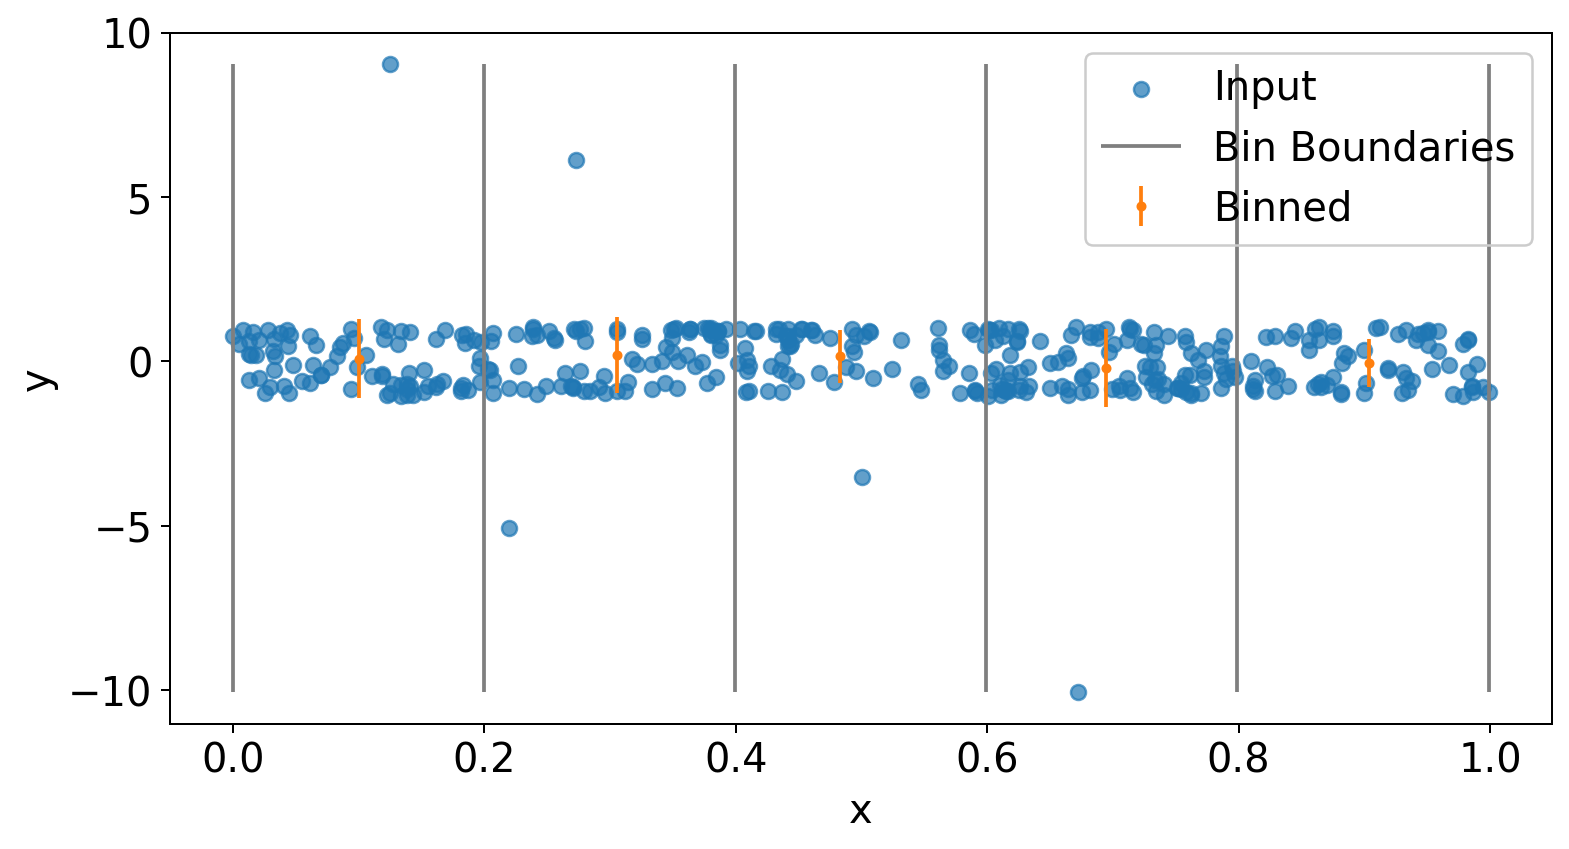

In [ ]:
bng = binning.Binning(
    nintervals=5, npoints_per_interval=None,
    xmin=None, xmax=None,
    ddof=0,
    verbose=3
)

x_binned, y_binned, y_std = bng.fit_transform(ph, y)

fig, axs = bng.plot_result()

## Fixed number of bins (fraction of dataseries length)

INFO(Binning): Generated 40 bins


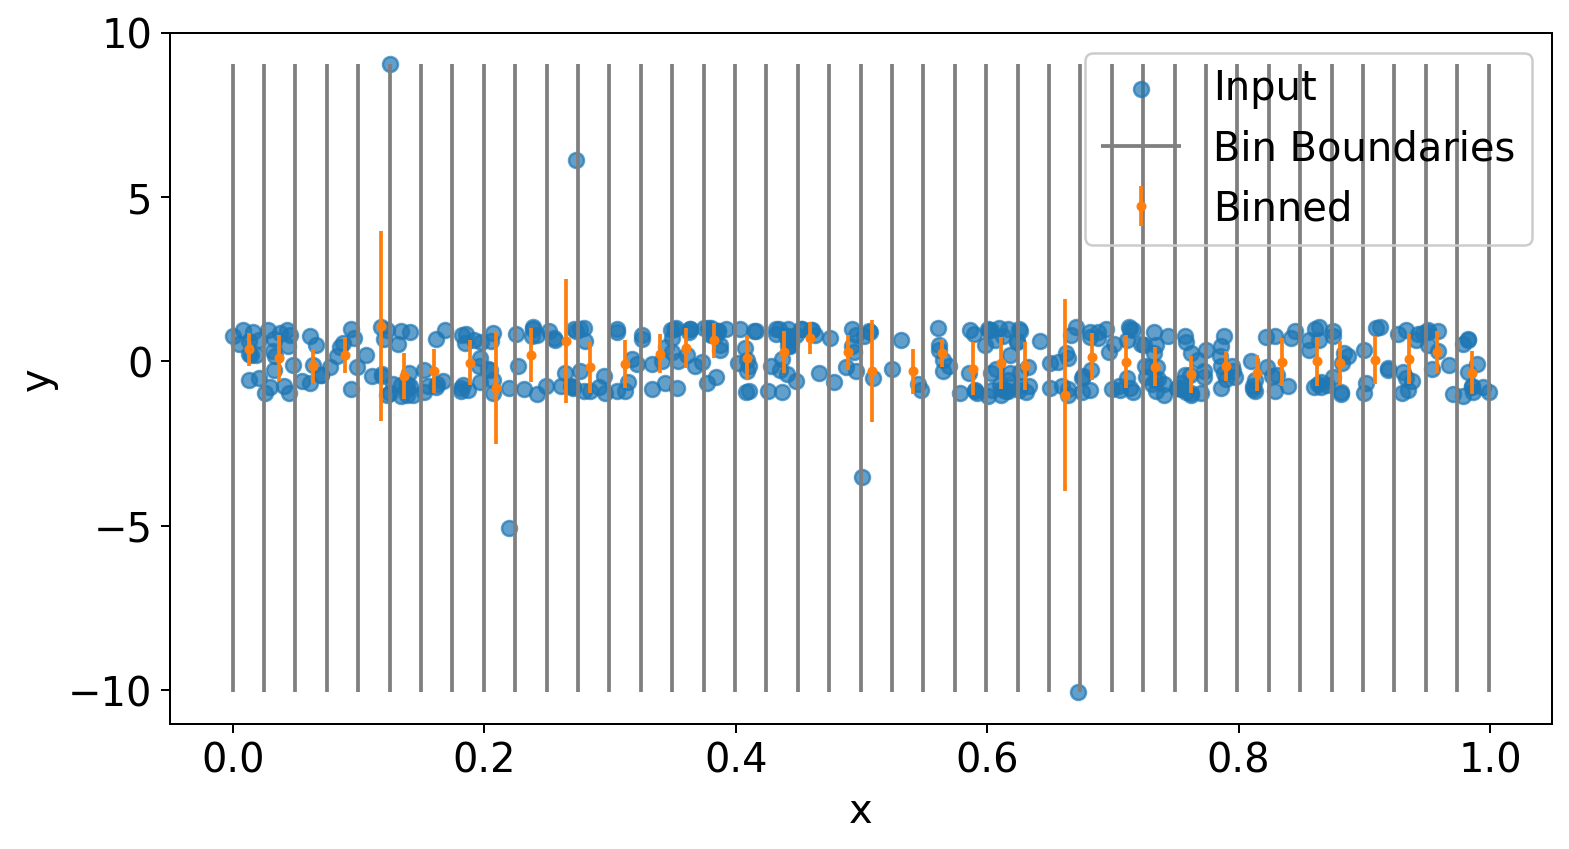

In [ ]:
bng = binning.Binning(
    nintervals=0.1, npoints_per_interval=None,
    xmin=None, xmax=None,
    ddof=0,
    verbose=3
)

x_binned, y_binned, y_std = bng.fit_transform(ph, y)

fig, axs = bng.plot_result()

## Fixed number of datapoints per bin

INFO(Binning): Generated 14 bins


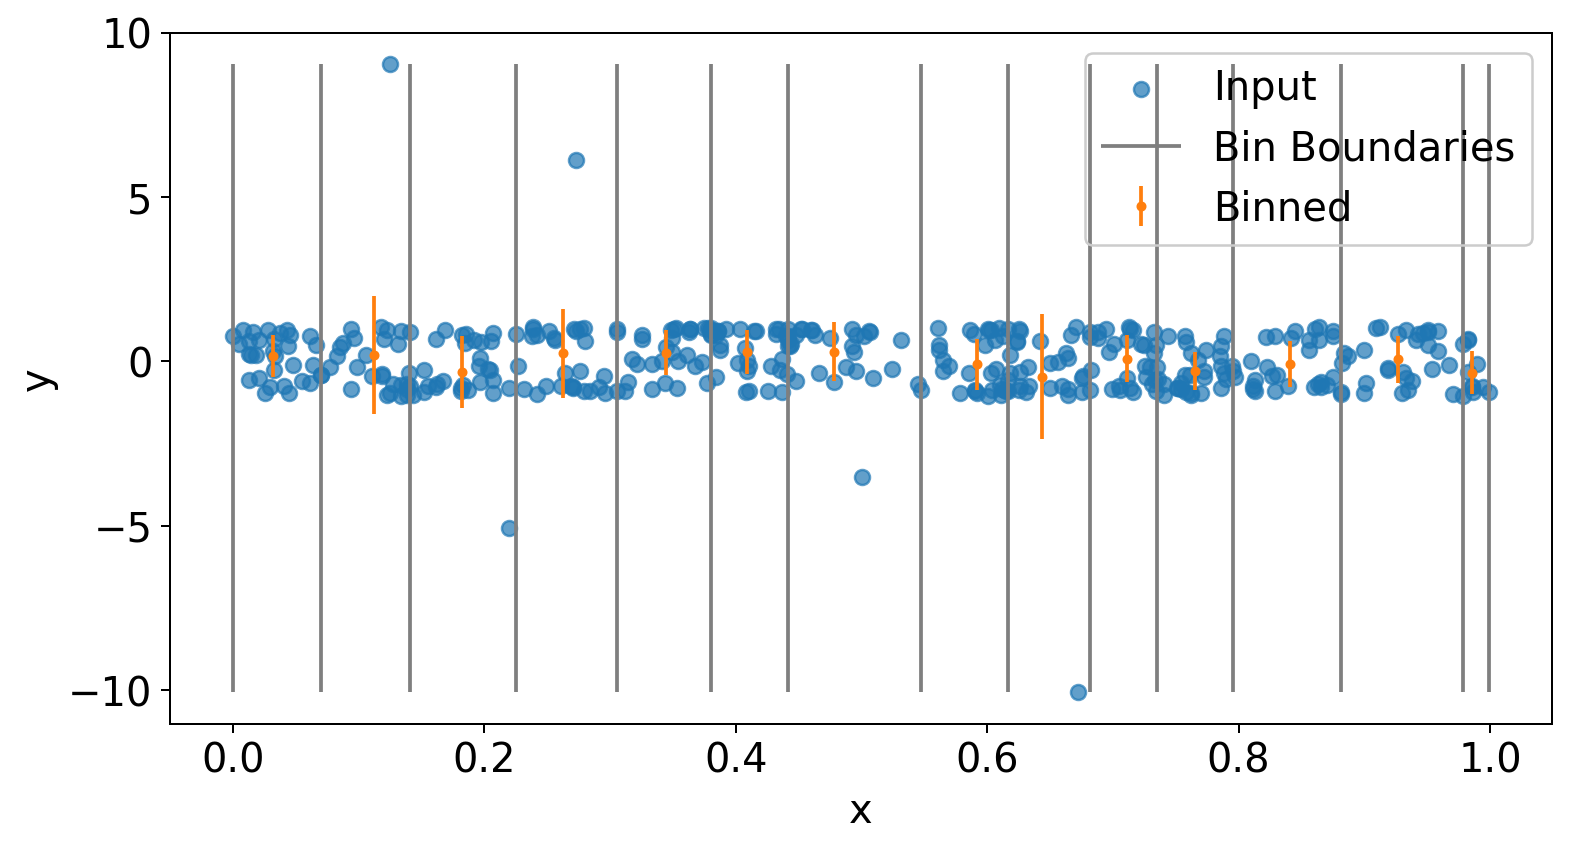

In [ ]:
bng = binning.Binning(
    nintervals=5, npoints_per_interval=30,
    xmin=None, xmax=None,
    ddof=0,
    verbose=3
)

x_binned, y_binned, y_std = bng.fit_transform(ph, y)

fig, axs = bng.plot_result()